### Section 1: Loading Libraries & Settings

This initial block is the setup phase for the entire project.

* **Imports:** We import all the necessary libraries:

    * `os`, `pathlib`, `shutil`: For interacting with the operating system, like creating folders and copying files.
    * `cv2` (OpenCV): A powerful library for image processing, although its direct use is minimized in the final version in favor of TensorFlow's tools.
    * `numpy`: The fundamental package for numerical operations in Python.
    * `tensorflow` and `keras`: The core deep learning framework used to build and train our neural network.
    * `matplotlib.pyplot` and `seaborn`: For creating all the data visualizations and plots.
    * `sklearn.metrics`: To generate the final classification report and confusion matrix.

* **Basic Settings:** We define key parameters that will be used throughout the script:

    * `IMG_SIZE`: Sets a standard size (128x128 pixels) for all images. This is crucial because a neural network requires inputs of a consistent shape.
    * `BATCH_SIZE`: Defines the number of images the model will process at once during training (32).
    * `EPOCHS`: The number of times the model will go through the entire training dataset (15).

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import random
import requests
import zipfile
import tarfile
import io


In [2]:
import shutil

In [3]:
# Basic Settings
IMG_SIZE = 128  # Resize all images to 128x128
BATCH_SIZE = 32
EPOCHS = 30

### Section 2: Preparing Datasets from Local Folders

This is the most critical pre-processing step. Its goal is to create a large, clean, and balanced dataset ready for training.

* **Manual Setup:** The script is designed to work with locally downloaded datasets to avoid network errors. It expects the `car-plate-detection` and `car_data` folders to be in the project directory.
* **Offline Data Augmentation:** We define a powerful augmentation pipeline (`offline_data_augmentation`). Because we only have a few hundred original license plate images, we use this pipeline to generate new, modified versions (rotated, zoomed, shifted, etc.) and save them to the disk. This process artificially increases our dataset size to the `TARGET_IMAGES_PER_CLASS` (2000), providing the model with much more data to learn from.
* **Structured Directory Creation:** The script creates a `final_dataset` folder with two subdirectories: `plate` and `no_plate`. It then populates these folders.
* **Memory-Efficient Data Loading:** Instead of loading all 4000 images into RAM (which would cause a crash), we use `tf.keras.utils.image_dataset_from_directory`. This powerful utility creates a `tf.data.Dataset` object that streams images from the disk in batches.
* **Train/Validation/Test Split:** The dataset is split into three parts: Training (64%), Validation (16%), and Test (20%).
* **Visual Verification:** The script plots a sample batch of images to provide a visual confirmation that the data has been loaded correctly.



--- Section 2: Preparing Datasets from Local Folders ---
Structured dataset with ~2000 images/class already exists. Skipping creation.

Creating TensorFlow data loaders...
Found 2433 files belonging to 2 classes.
Using 1947 files for training.
Using 486 files for validation.
Number of training batches: 61
Number of validation batches: 8
Number of test batches: 8
Classes found: ['no_plate', 'plate']

--- Visualizing Sample Preprocessed Data ---
Sample batch class distribution: {'no_plate': np.int64(5), 'plate': np.int64(27)}


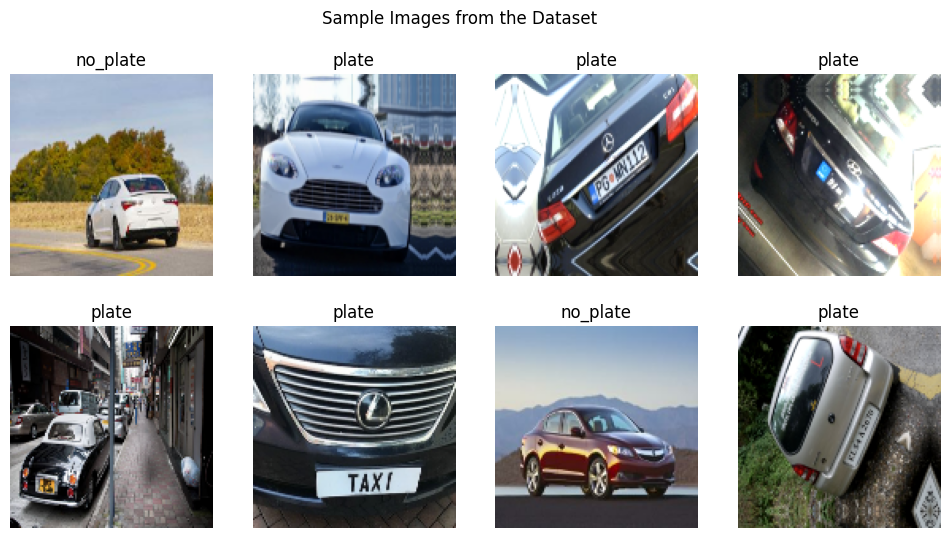

In [4]:
print("\n--- Section 2: Preparing Datasets from Local Folders ---")

# Define paths to your manually downloaded and unzipped folders
lp_source_folder = Path("car-plate-detection/images")
cars_source_folder = Path("car_data/car_data")

# Define the final, structured dataset directory
dataset_dir = Path("final_dataset")
TARGET_IMAGES_PER_CLASS = 2000

# Check if the source folders exist before proceeding
if not lp_source_folder.exists():
    print(f"FATAL ERROR: Positive dataset not found at '{lp_source_folder}'")
    print("Please download and unzip the 'car-plate-detection' dataset into your project folder.")
    exit()
if not cars_source_folder.exists():
    print(f"FATAL ERROR: Negative dataset not found at '{cars_source_folder}'")
    print("Please download and unzip the 'car-connection-picture-dataset' into your project folder.")
    exit()

# Define an augmentation pipeline for creating new images on disk
offline_data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(height_factor=0.15, width_factor=0.15),
        layers.RandomBrightness(0.3),
        layers.RandomContrast(0.3),
    ],
    name="offline_data_augmentation",
)

# If the final_dataset directory already has enough images, skip creation
plate_check_dir = dataset_dir / "plate"
if dataset_dir.exists() and plate_check_dir.exists() and len(list(plate_check_dir.glob('*.*'))) >= TARGET_IMAGES_PER_CLASS:
    print(f"Structured dataset with ~{TARGET_IMAGES_PER_CLASS} images/class already exists. Skipping creation.")
else:
    if dataset_dir.exists():
        print("Incomplete dataset found. Clearing and recreating...")
        shutil.rmtree(dataset_dir)
        
    print(f"\nCreating structured dataset with {TARGET_IMAGES_PER_CLASS} images per class...")
    # Create subdirectories for each class
    plate_dir = dataset_dir / "plate"
    no_plate_dir = dataset_dir / "no_plate"
    plate_dir.mkdir(parents=True, exist_ok=True)
    no_plate_dir.mkdir(parents=True, exist_ok=True)

    # 1. Load, augment, and save POSITIVE class images
    print("Augmenting positive class (license plates)...")
    plate_image_paths = list(lp_source_folder.glob('*.*'))
    num_original_plates = len(plate_image_paths)
    
    # First, copy all original images
    for img_path in plate_image_paths:
        shutil.copy(img_path, plate_dir / img_path.name)
    
    # Now, generate new augmented images until we reach the target
    num_augmented_needed = TARGET_IMAGES_PER_CLASS - num_original_plates
    if num_augmented_needed > 0:
        print(f"Generating {num_augmented_needed} new images from {num_original_plates} originals...")
        images_generated = 0
        while images_generated < num_augmented_needed:
            random_img_path = random.choice(plate_image_paths)
            img = tf.keras.utils.load_img(random_img_path)
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)
            augmented_img_array = offline_data_augmentation(img_array)
            new_filename = f"aug_{images_generated}_{random_img_path.name}"
            tf.keras.utils.save_img(plate_dir / new_filename, augmented_img_array[0])
            images_generated += 1
            if images_generated % 200 == 0:
                print(f"  ...generated {images_generated}/{num_augmented_needed} images...")

    print(f"Total positive images created: {len(list(plate_dir.glob('*.*')))}")

    # 2. Load and copy NEGATIVE class images
    print("Copying negative class (general car photos)...")
    negative_image_paths = list(cars_source_folder.glob('*.jpg'))
    random.shuffle(negative_image_paths)
    
    num_to_copy = min(TARGET_IMAGES_PER_CLASS, len(negative_image_paths))
    for i in range(num_to_copy):
        img_path = negative_image_paths[i]
        shutil.copy(img_path, no_plate_dir / img_path.name)
    print(f"Copied {num_to_copy} negative samples.")

# --- Create TensorFlow Datasets from Directories ---
print("\nCreating TensorFlow data loaders...")
try:
    # Create a dataset for training and validation (80% of data)
    train_val_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        validation_split=0.2,
        subset="both",
        seed=1337,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
    )
    train_ds, val_ds = train_val_ds
except ValueError as e:
    print(f"\nFATAL ERROR: {e}")
    print("This usually means no images were found. Please check your folder structure and file permissions.")
    exit()

# Create a separate dataset for testing
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds)}")

class_names = train_ds.class_names
print(f"Classes found: {class_names}")

# --- VISUALIZATION 1 & 2: Sample Preprocessed Data & Class Distribution ---
print("\n--- Visualizing Sample Preprocessed Data ---")
plt.figure(figsize=(12, 6))
plt.suptitle("Sample Images from the Dataset")
for images, labels in train_ds.take(1): # Take one batch
    # Count class distribution in the batch
    unique, counts = np.unique(labels.numpy(), return_counts=True)
    print(f"Sample batch class distribution: {dict(zip(class_names, counts))}")
    # Show sample images
    for i in range(min(8, len(images))): # Show up to 8 images
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Section 3: Building the CNN Model

This section defines the architecture of our neural network.


* **Online Data Augmentation:** We define a `data_augmentation` layer that applies random transformations to the images *during* the training process itself.
* **The Functional API:** The model is built using the Keras Functional API, which is more explicit and robust.
* **Core CNN Layers:**
    * **Convolutional Layer (`Conv2D`):** Slides filters over the image to detect patterns like edges, corners, and textures. text=Convolution+Animation
    * **Activation Function (`relu`):** Introduces non-linearity by changing all negative pixel values to zero, helping the network learn complex relationships.
    * **Max Pooling Layer (`MaxPooling2D`):** Shrinks the feature maps, reducing computation and helping the model recognize features regardless of their exact location.
* **Classifier Head:**
    * **Flatten:** Converts the 2D feature map into a 1D vector.
    * **Dense:** A standard fully-connected layer that performs the final classification.
    * **Dropout:** A regularization technique to prevent overfitting.
    * **Output Layer:** The final `Dense` layer with two neurons, one for each class.


--- Section 3: Building the CNN Model ---

--- Visualizing Data Augmentation Effects ---


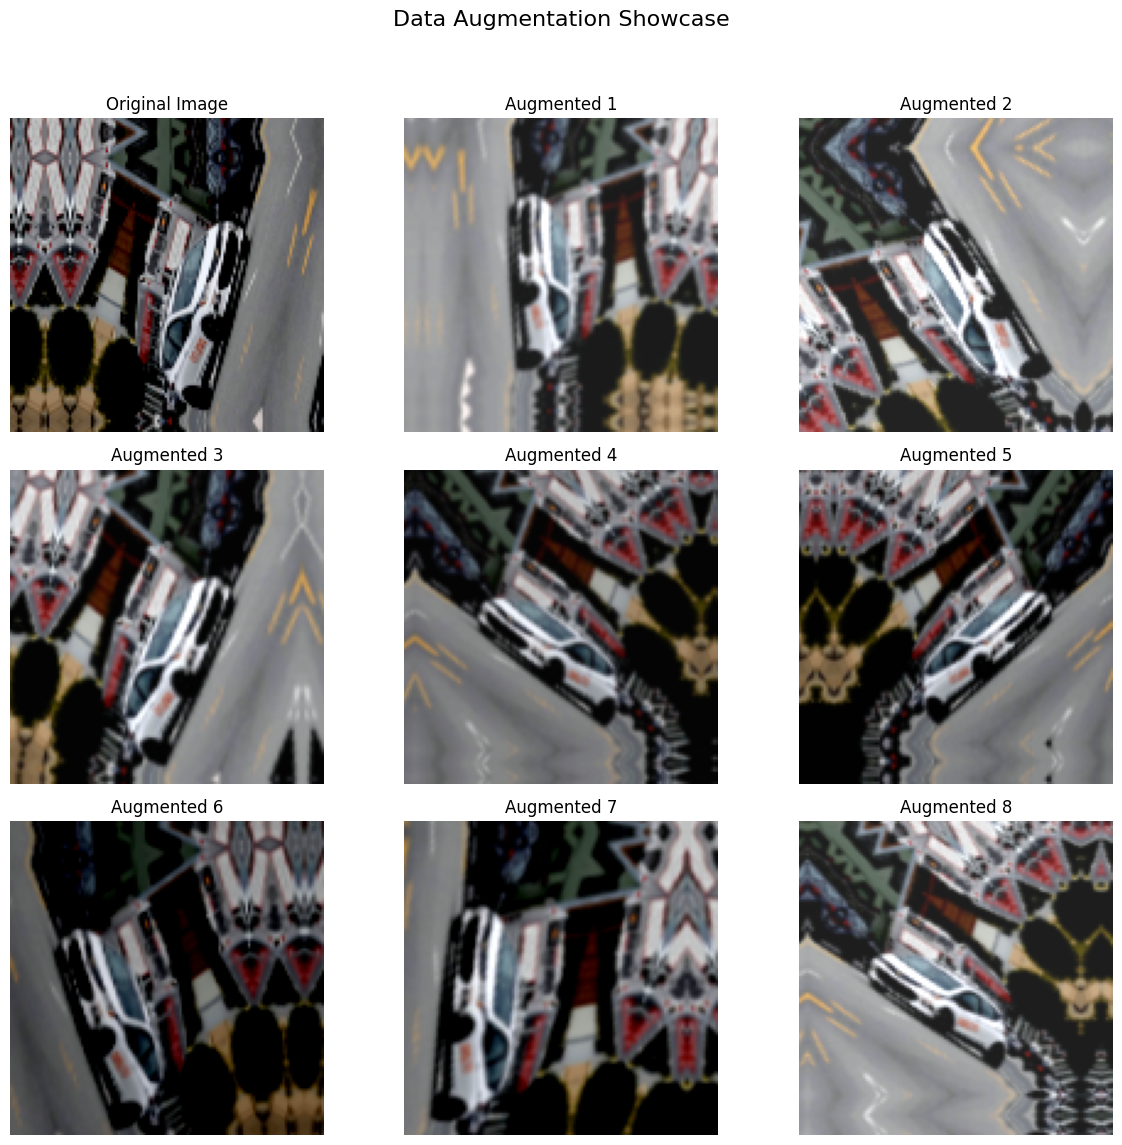

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)


--- Visualizing Model Architecture ---
Model architecture plot saved as model_architecture.png


In [5]:
print("\n--- Section 3: Building the CNN Model ---")
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
    ],
    name="data_augmentation",
)

# --- VISUALIZATION 3: Data Augmentation Effects ---
print("\n--- Visualizing Data Augmentation Effects ---")
for images, _ in train_ds.take(1):
    sample_image = images[0]
    plt.figure(figsize=(12, 12))
    plt.suptitle("Data Augmentation Showcase", fontsize=16)
    plt.subplot(3, 3, 1)
    plt.imshow(sample_image.numpy().astype("uint8"))
    plt.title("Original Image")
    plt.axis('off')
    for i in range(8):
        augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
        plt.subplot(3, 3, i + 2)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(f"Augmented {i+1}")
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    break # Only need to do this for one batch

# --- Build Model using the Functional API (more robust) ---
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_1')(x)
x = layers.MaxPooling2D((2, 2), name='max_pooling2d_1')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_2')(x)
x = layers.MaxPooling2D((2, 2), name='max_pooling2d_2')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', name='conv2d_3')(x)
x = layers.MaxPooling2D((2, 2), name='max_pooling2d_3')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names))(x)

model = keras.Model(inputs, outputs)
model.summary()

# --- VISUALIZATION 4: Model Architecture Plot ---
print("\n--- Visualizing Model Architecture ---")
try:
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_activations=True)
    print("Model architecture plot saved as model_architecture.png")
except ImportError:
    print("Could not create model plot. Please install pydot and graphviz.")

### Section 4: Compiling the Model

Before the model can be trained, it needs to be compiled. This step configures the training process.

* **Optimizer (`adam`):** The algorithm that adjusts the model's internal parameters to minimize the error. Adam is a popular and effective choice.
* **Loss Function (`SparseCategoricalCrossentropy`):** Measures how wrong the model's predictions are compared to the true labels. The optimizer's goal is to minimize this value.
* **Metrics (`accuracy`):** The metric we monitor to judge the model's performance during training.


In [6]:
print("\n--- Section 4: Compiling the Model ---")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


--- Section 4: Compiling the Model ---


### Section 5: Training the Model

This is where the learning happens.

* **`model.fit()`:** This command starts the training loop. The model iterates through the training data for the specified number of `EPOCHS`. In each epoch, it makes predictions, calculates the loss, and uses the optimizer to update its internal weights. It also evaluates its performance on the validation set at the end of each epoch.


In [7]:
print("\n--- Section 5: Starting Model Training ---")
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
print("\nTraining finished!")


--- Section 5: Starting Model Training ---
Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 520ms/step - accuracy: 0.7869 - loss: 21.1079 - val_accuracy: 0.8522 - val_loss: 0.3718
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 470ms/step - accuracy: 0.8305 - loss: 0.4490 - val_accuracy: 0.8783 - val_loss: 0.3543
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 418ms/step - accuracy: 0.8485 - loss: 0.3838 - val_accuracy: 0.9043 - val_loss: 0.3174
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 385ms/step - accuracy: 0.8634 - loss: 0.3515 - val_accuracy: 0.8870 - val_loss: 0.3600
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 240ms/step - accuracy: 0.8541 - loss: 0.3831 - val_accuracy: 0.9043 - val_loss: 0.2975
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.8557 - loss: 0.3505 - val_accuracy: 0.8826 - val_loss: 0.3168
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.8654 - loss: 0.3560 - val_accuracy: 0.9130 - val_loss: 0.2333
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step

### Section 6: Evaluating on the Test Set

After training is finished, this section provides the final, unbiased measure of the model's performance.

* **`model.evaluate()`:** This command runs the trained model on the test set, which it has never seen before. The resulting accuracy is the most reliable indicator of how the model will perform in the real world.



--- Section 6: Evaluating on Test Set ---
8/8 - 1s - 68ms/step - accuracy: 0.9375 - loss: 0.1760

Test Loss:     0.1760
Test Accuracy: 0.9375 (93.75%)

--- Visualizing Training History ---


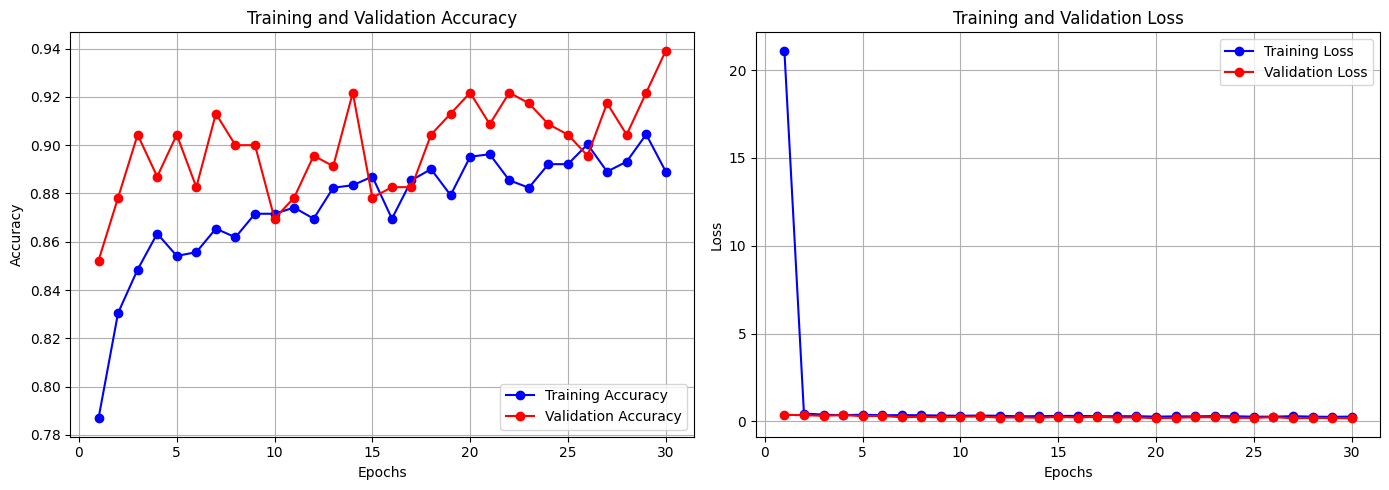


--- Visualizing Feature Maps of the Trained Model ---


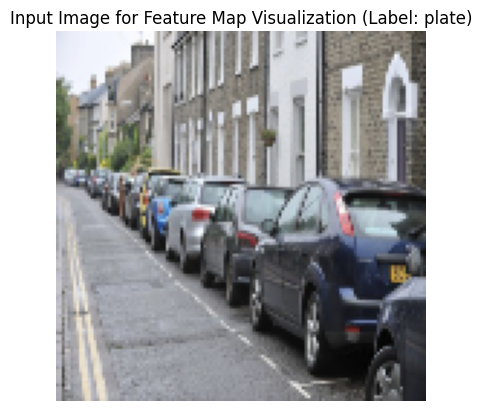

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


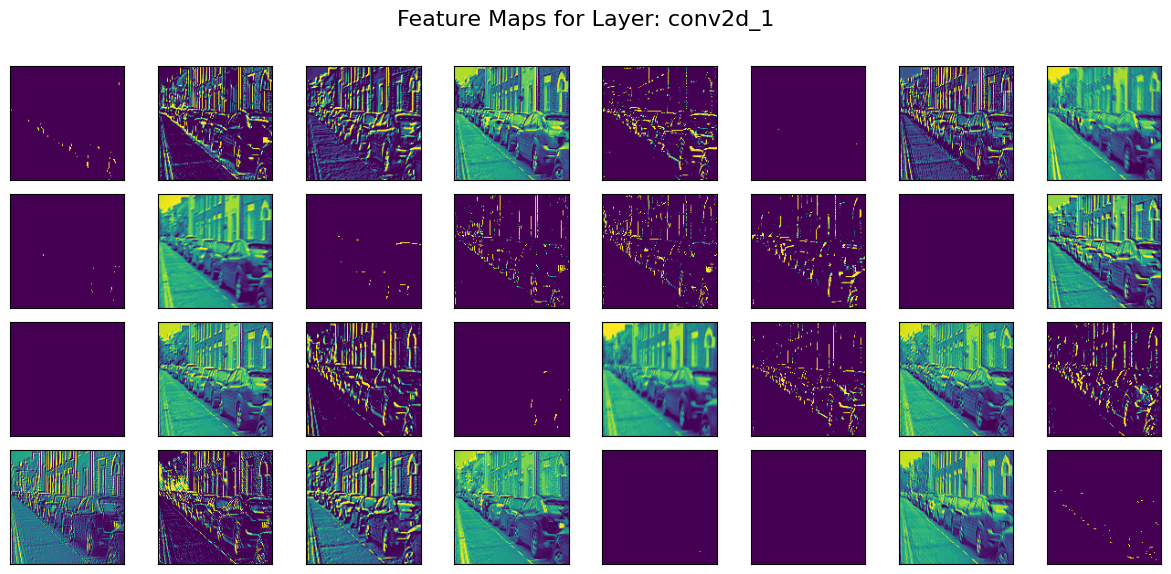

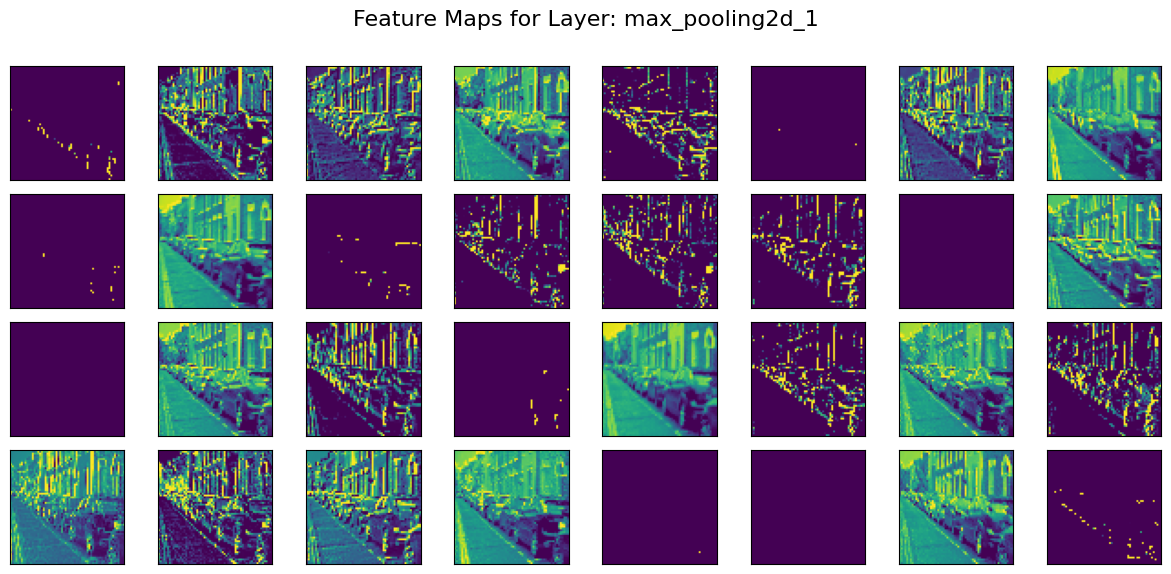

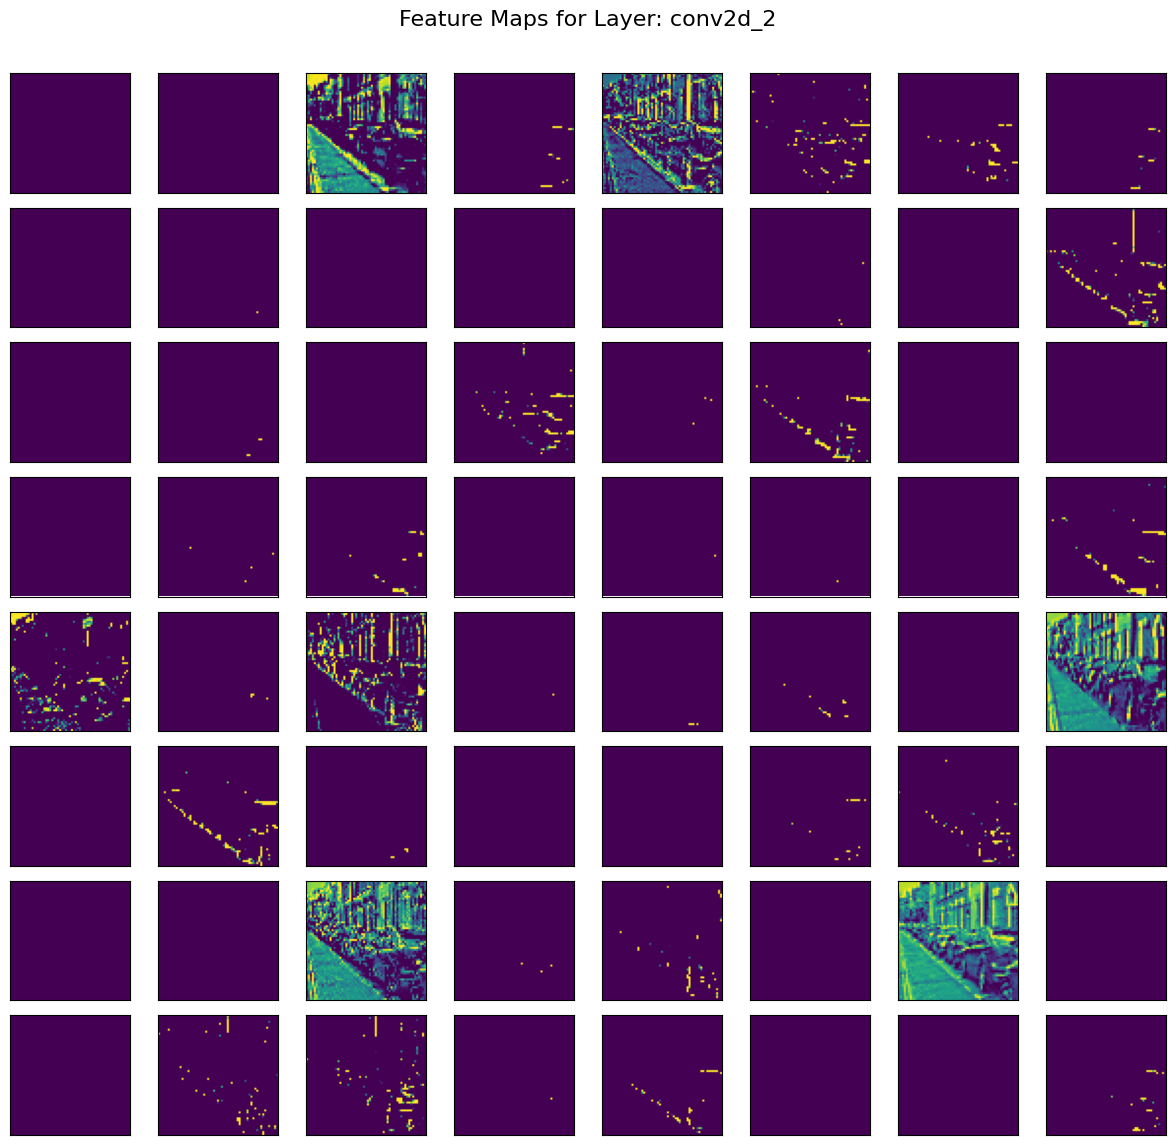

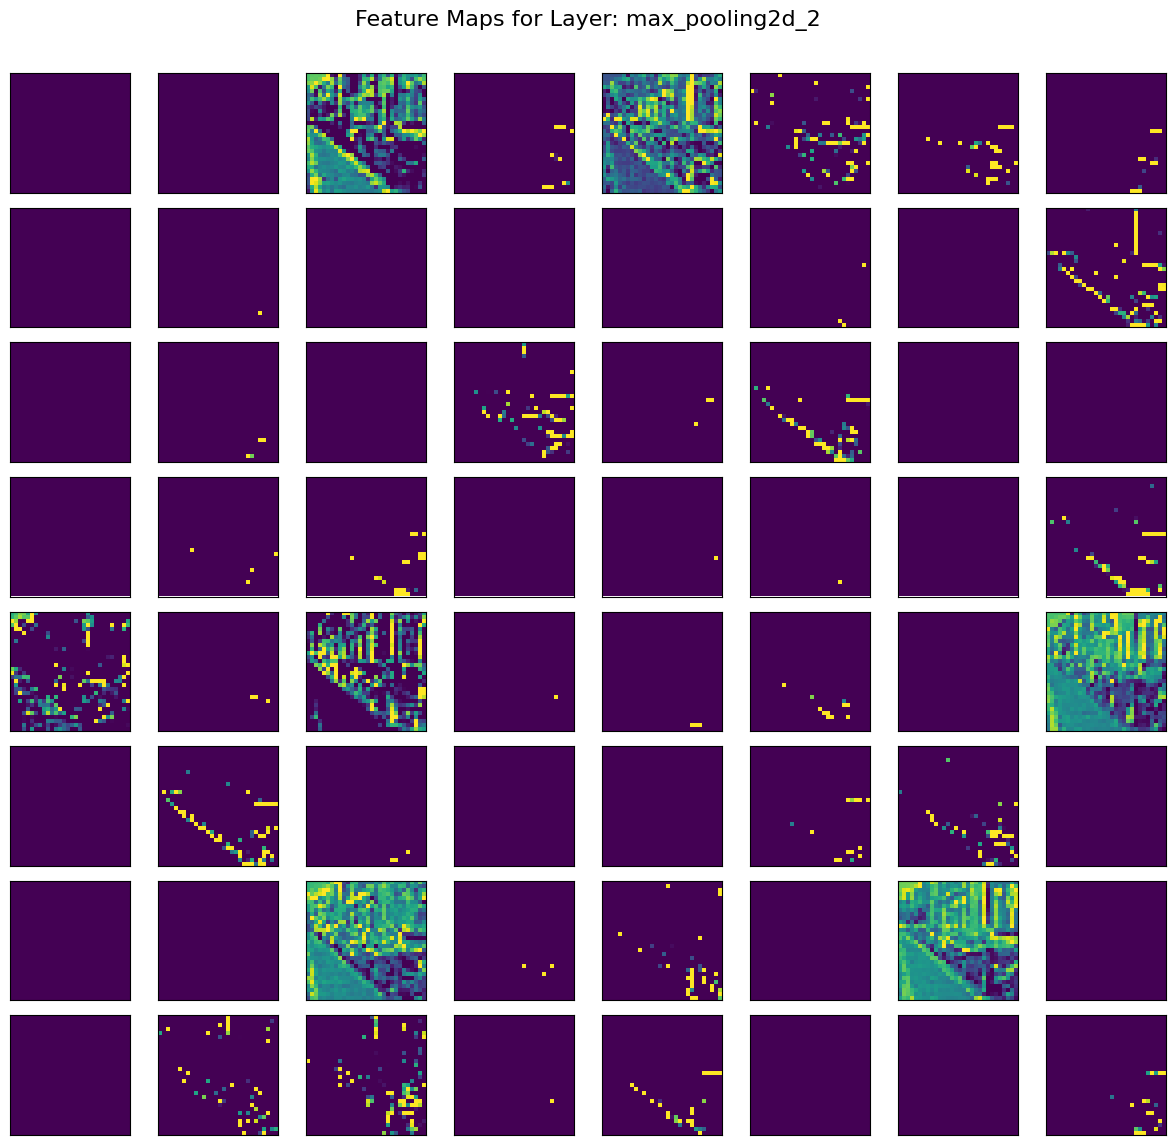

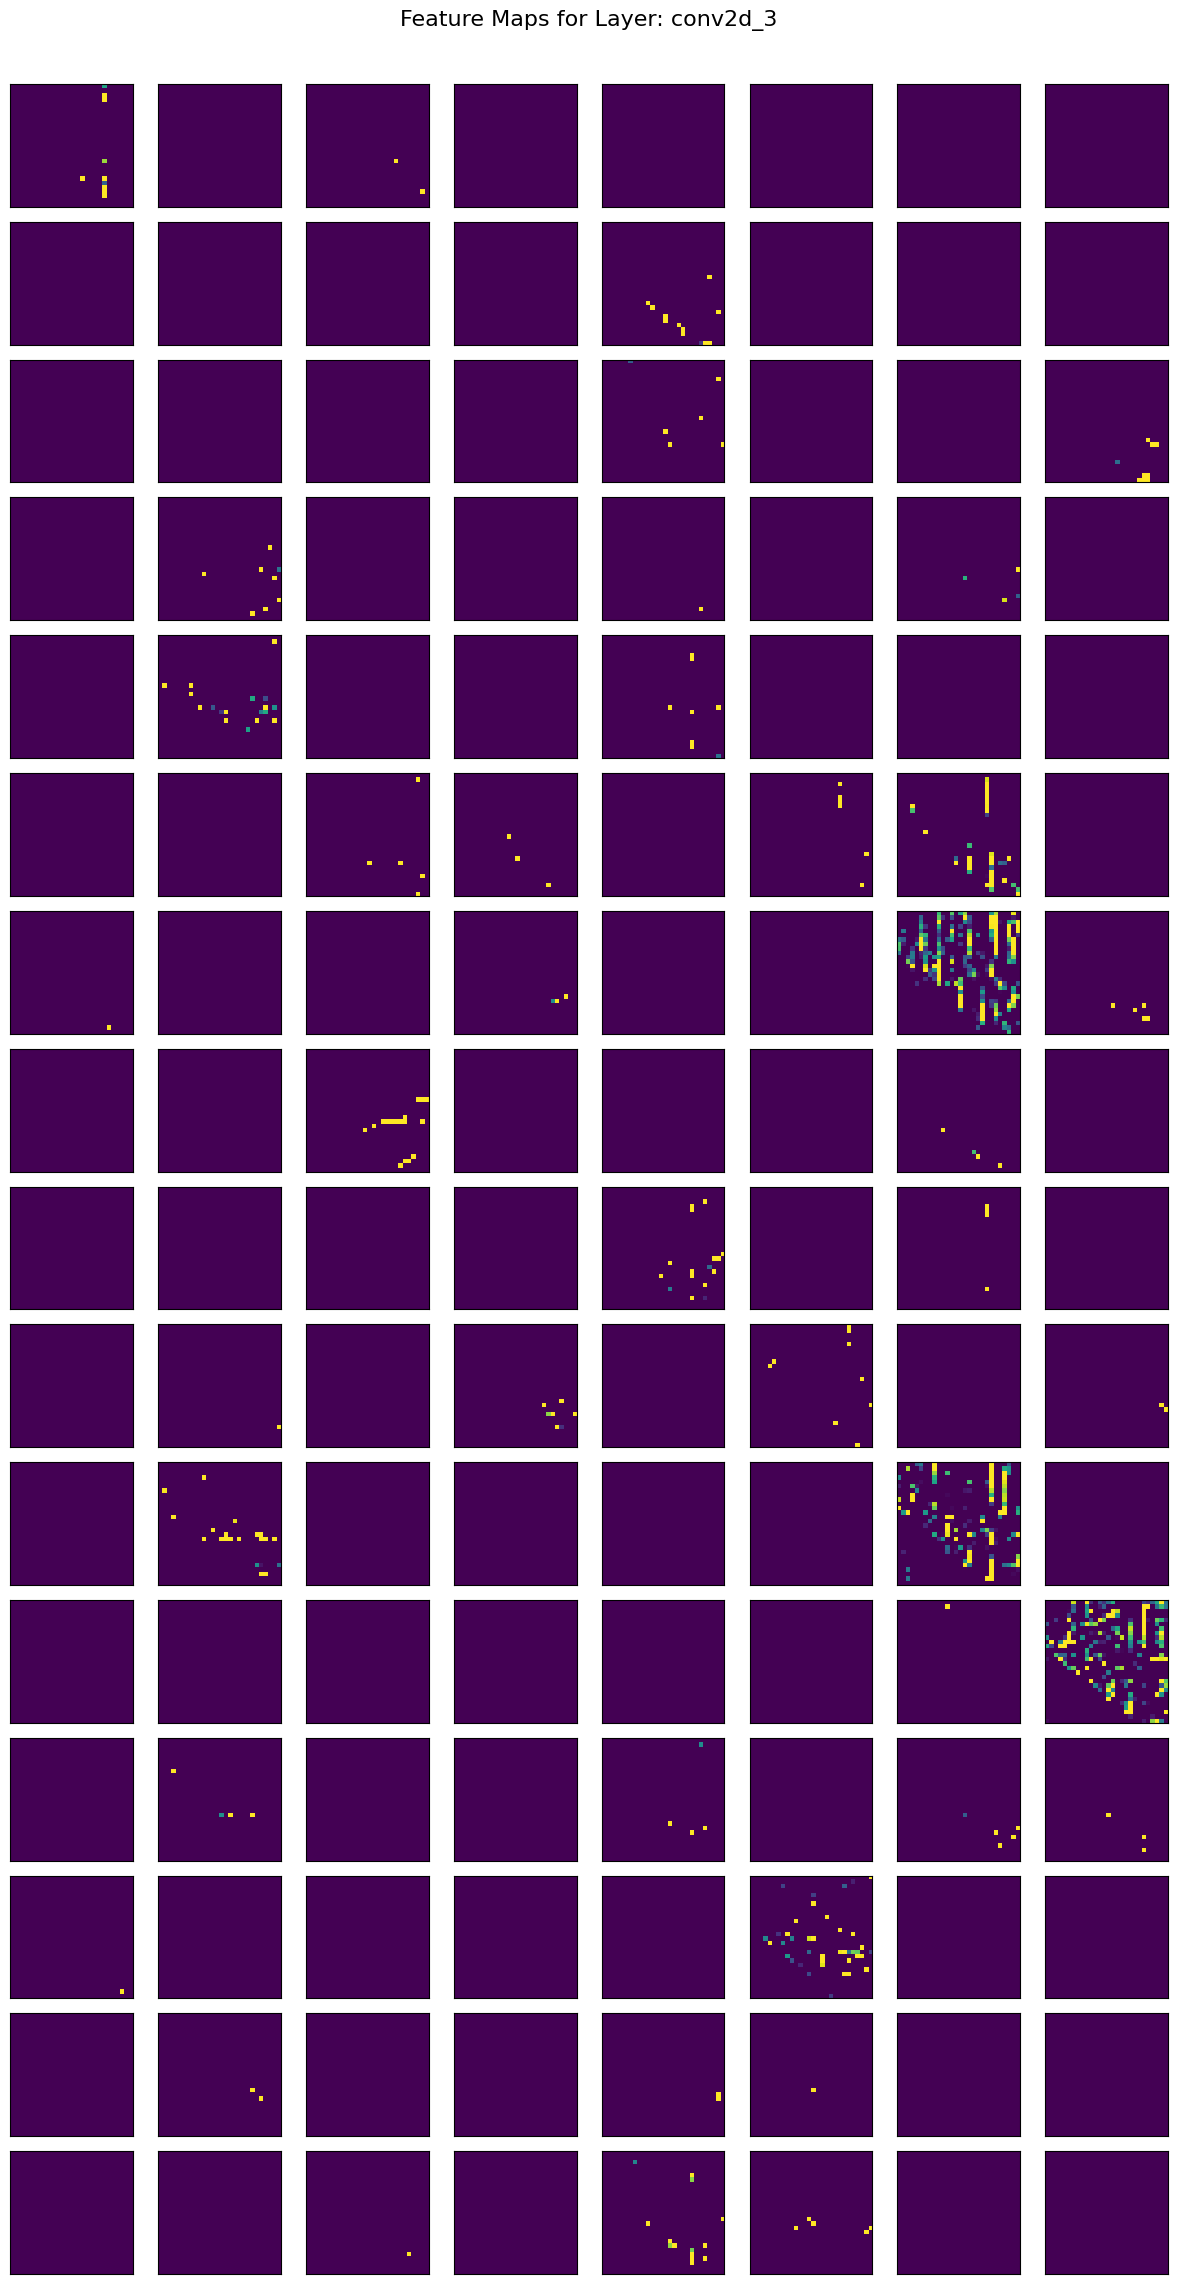

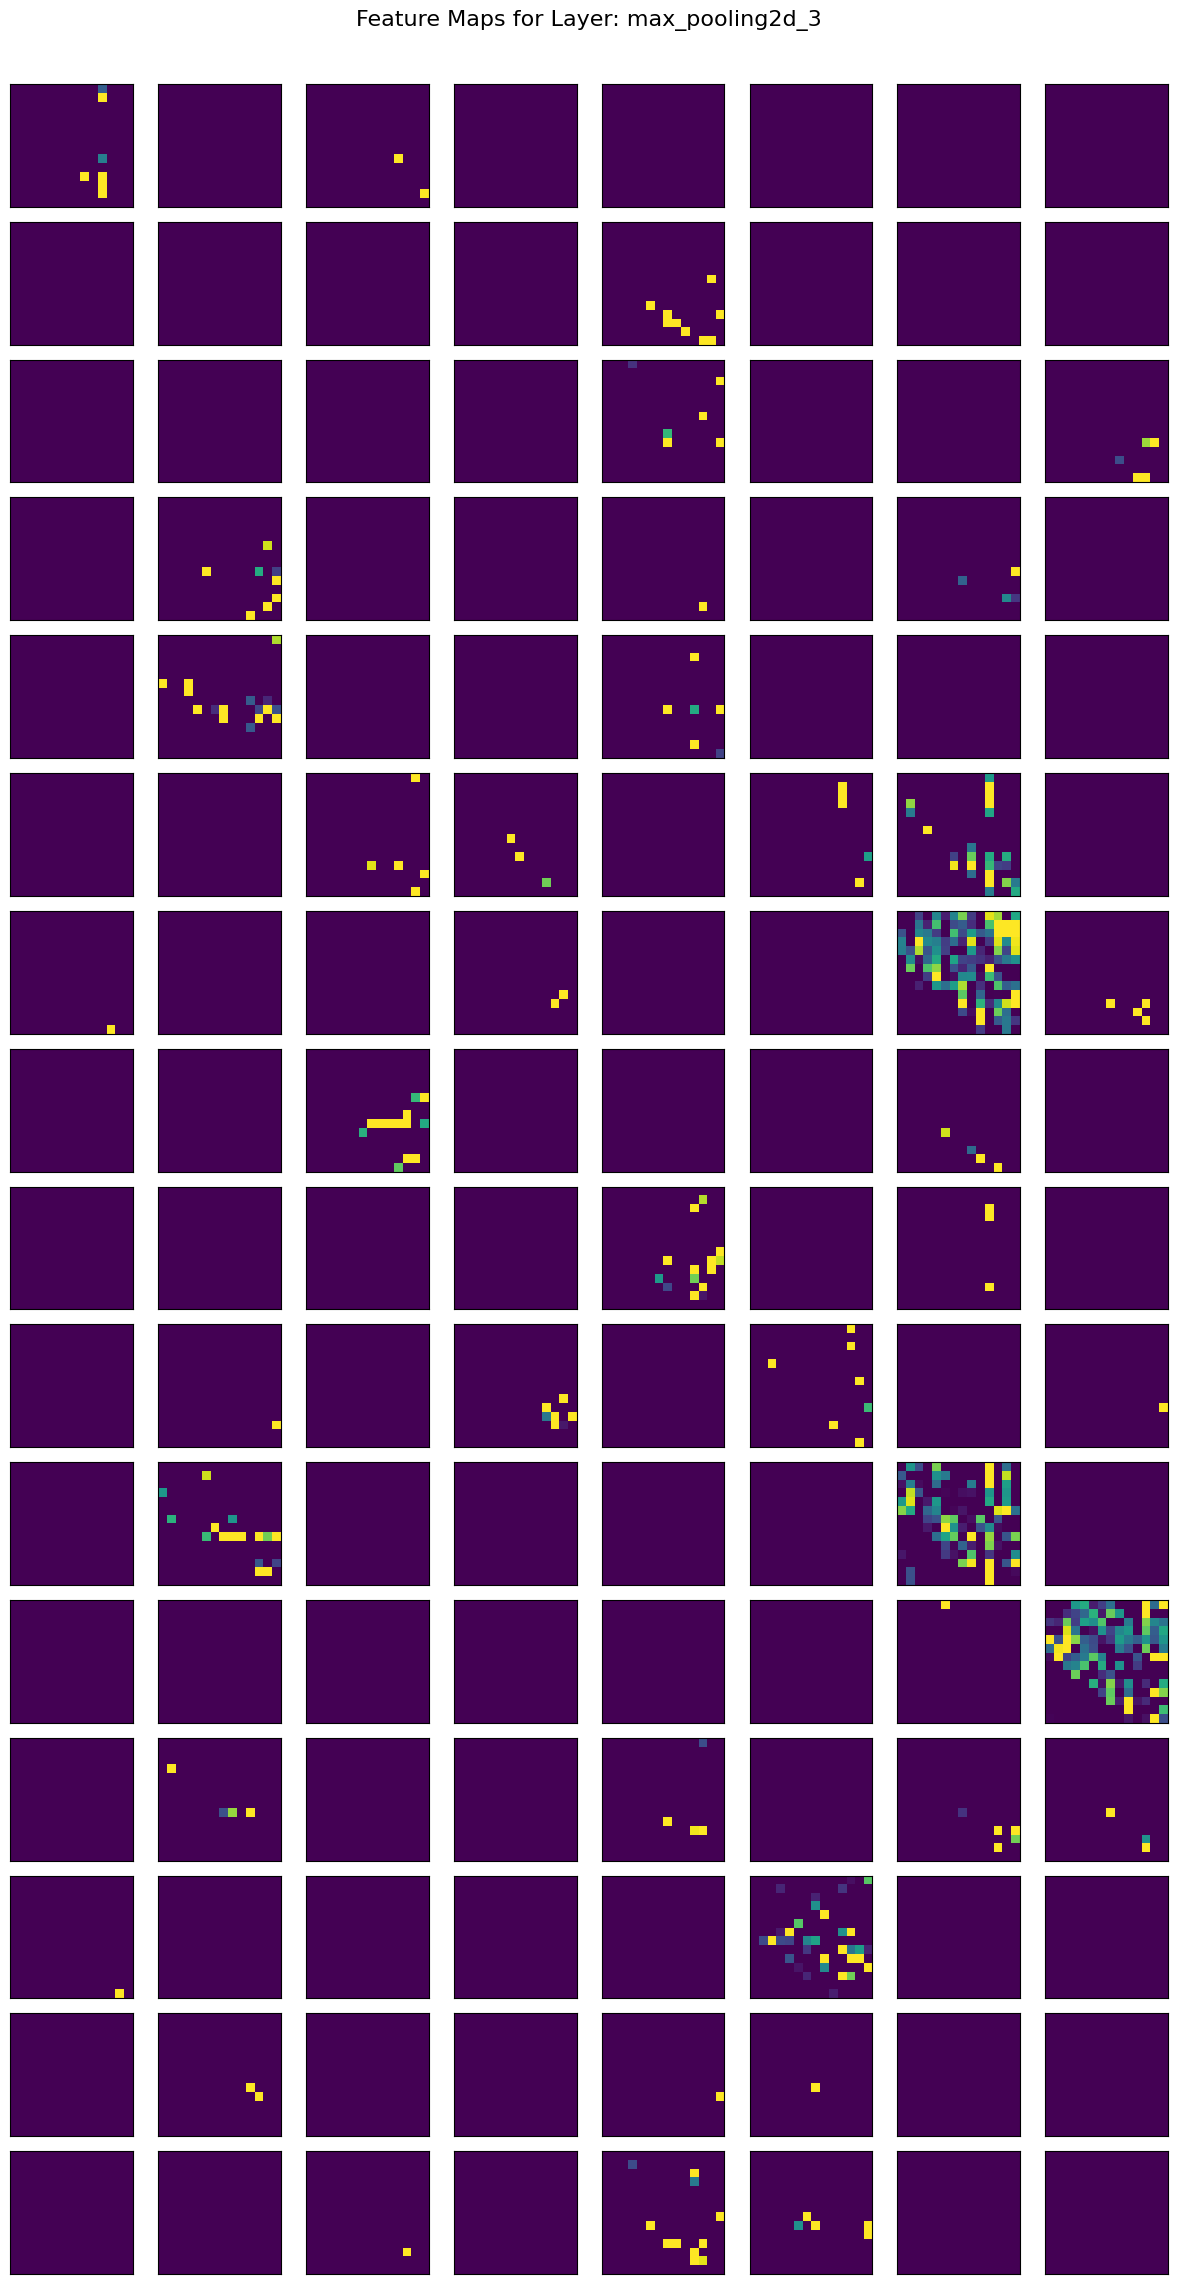

In [8]:
print("\n--- Section 6: Evaluating on Test Set ---")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)
print(f"\nTest Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# --- VISUALIZATION 6: Training Curves ---
print("\n--- Visualizing Training History ---")
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs_range = range(1, len(acc) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- VISUALIZATION 5: Feature Maps from Conv/Pool Layers (MOVED HERE) ---
print("\n--- Visualizing Feature Maps of the Trained Model ---")
for images, labels in test_ds.take(1):
    # Find a plate image in the batch
    if 'plate' in class_names:
        plate_indices = tf.where(labels == class_names.index('plate'))
        if plate_indices.shape[0] > 0:
            idx_of_first_plate = plate_indices[0][0]
            sample_image_for_viz = tf.expand_dims(images[idx_of_first_plate], axis=0)
            
            plt.figure()
            plt.imshow(sample_image_for_viz[0].numpy().astype("uint8"))
            plt.title(f"Input Image for Feature Map Visualization (Label: plate)")
            plt.axis('off')
            plt.show()

            layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]
            layer_names = [layer.name for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]
            activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
            activations = activation_model.predict(sample_image_for_viz)

            for layer_name, layer_activation in zip(layer_names, activations):
                n_features = layer_activation.shape[-1]
                n_cols = 8
                n_rows = (n_features + n_cols - 1) // n_cols
                plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
                plt.suptitle(f"Feature Maps for Layer: {layer_name}", fontsize=16)
                for i in range(n_features):
                    ax = plt.subplot(n_rows, n_cols, i + 1)
                    feature_map = layer_activation[0, :, :, i]
                    feature_map -= feature_map.mean()
                    std = feature_map.std()
                    if std > 0:
                        feature_map /= std
                    feature_map = np.clip((feature_map * 64) + 128, 0, 255).astype('uint8')
                    ax.imshow(feature_map, cmap='viridis')
                    ax.set_xticks([])
                    ax.set_yticks([])
                plt.tight_layout(rect=[0, 0.03, 1, 0.97])
                plt.show()
            break # Break after visualizing one image

### Section 7 & 8: Visualizations and Final Reports

This final part of the script is dedicated to analyzing and understanding the trained model's performance in detail.

* **Training Curves:** Plots the training and validation accuracy/loss over each epoch. This is the primary tool for diagnosing issues like overfitting. 
* **Feature Maps:** A visualization that shows what the *trained* model "sees" inside an image by plotting the output of each convolutional and pooling layer.
* **Confusion Matrix:** A table that gives a detailed breakdown of the model's predictions, showing true positives, true negatives, false positives, and false negatives. 
* **Classification Report:** Provides key metrics like **precision**, **recall**, and the **F1-score** for each class.
* **Sample Predictions:** Shows a gallery of random images from the test set with their actual label and the model's predicted label, colored for correctness.



--- Section 8: Generating Final Reports ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


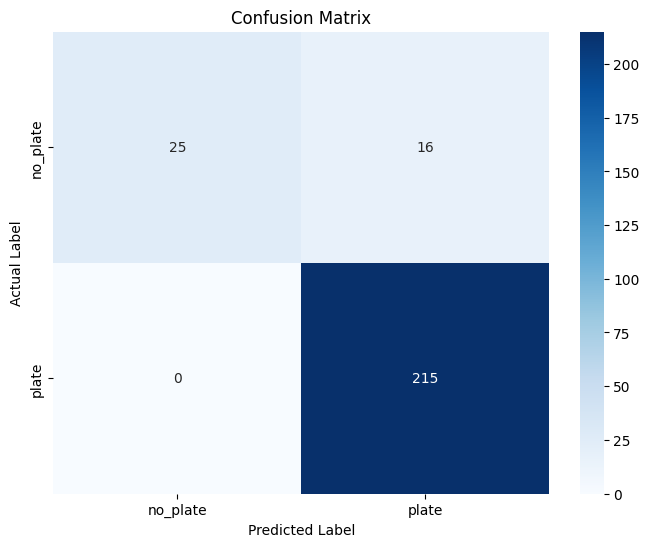


Classification Report
              precision    recall  f1-score   support

    no_plate       1.00      0.61      0.76        41
       plate       0.93      1.00      0.96       215

    accuracy                           0.94       256
   macro avg       0.97      0.80      0.86       256
weighted avg       0.94      0.94      0.93       256


--- Visualizing Sample Predictions from Test Set ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


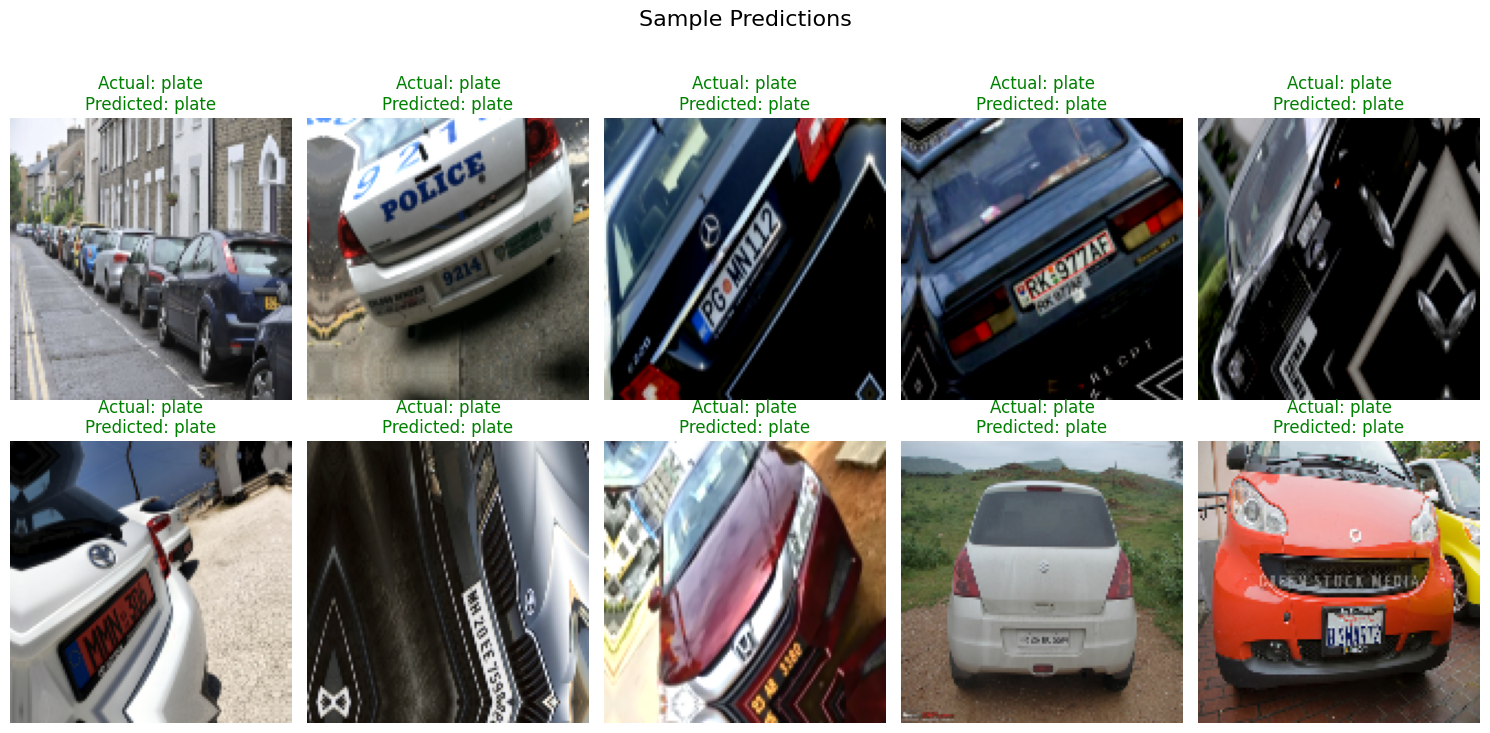


--- Script Finished ---


In [9]:
print("\n--- Section 8: Generating Final Reports ---")
# Get true labels and predictions for the entire test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- VISUALIZATION 7: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n" + "="*60)
print("Classification Report")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))
print("="*60)

# --- VISUALIZATION 8: Sample Predictions ---
print("\n--- Visualizing Sample Predictions from Test Set ---")
num_samples_to_show = 10
plt.figure(figsize=(15, 8))
plt.suptitle('Sample Predictions', fontsize=16)
for images, labels in test_ds.take(1): # Take one batch from test set
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    for i in range(min(num_samples_to_show, len(images))):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_label = class_names[labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        title_color = 'green' if actual_label == predicted_label else 'red'
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=title_color)
        plt.axis("off")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- Script Finished ---")



### Understanding the Classification Report

The classification report provides a deeper insight into the model's performance beyond simple accuracy. It breaks down the results for each class.

* **Precision:**
    * **Question it answers:** "Of all the times the model predicted a class (e.g., 'plate'), how often was it correct?"
    * **Analogy:** If you're fishing, precision is the percentage of your catch that is the target fish, not seaweed or other fish. High precision means the model's positive predictions are very reliable.
    * **Importance:** Crucial when the cost of a **False Positive** is high. You don't want to send a police car to a non-existent license plate.

* **Recall (Sensitivity):**
    * **Question it answers:** "Of all the *actual* instances of a class (e.g., all 'plate' images), how many did the model successfully identify?"
    * **Analogy:** Recall is the percentage of the target fish in the lake that you actually caught. High recall means the model is good at finding all instances of a class.
    * **Importance:** Crucial when the cost of a **False Negative** is high. In a security system, you want to identify every single license plate and not miss any.

* **F1-Score:**
    * **Question it answers:** "What is the balanced score between Precision and Recall?"
    * **Analogy:** The F1-score is the overall "grade" for your fishing trip, combining the quality (Precision) and quantity (Recall) of your catch into a single number.
    * **Importance:** It's the harmonic mean of Precision and Recall. It's a very useful metric when you need a single number to compare models, especially if there's an imbalance between the classes.

* **Support:**
    * This is simply the number of actual occurrences of the class in the test dataset. It's useful for context to see if one class has significantly more samples than another.